# LAB 4 - LOGISTIC REGRESSION (Part II)

In this lab, we will practice the following important packages: 

- 1. Data preprocessing: One-hot encoding (`sklearn.preprocessing`).

- 2. Classification modeling: logistic regression (`statsmodels`) and Linear Discrimative Analysis (`sklearn.discriminant_analysis`).

- 3. Model evaluation: confusion_matrix, accuracy_score, and the ROC curve (`sklearn.metrics`).


## 1. Logistic Regression (Numerical + Categorical Variables)

### 1.1 Data Loading

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

In [3]:
churn = pd.read_csv("customerchurn.csv")
churn.info()
churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            7032 non-null   int64  
 1   MonthlyCharges   7032 non-null   float64
 2   SeniorCitizen    7032 non-null   int64  
 3   PaymentMethod    7032 non-null   object 
 4   InternetService  7032 non-null   object 
 5   tenure           7032 non-null   int64  
 6   Contract         7032 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 384.7+ KB


,Churn,MonthlyCharges,SeniorCitizen,PaymentMethod,InternetService,tenure,Contract
0,0,29.85,0,Electronic check,DSL,1,Month-to-month
1,0,56.95,0,Mailed check,DSL,34,One year
2,1,53.85,0,Mailed check,DSL,2,Month-to-month
3,0,42.30,0,Bank transfer,DSL,45,One year
4,1,70.70,0,Electronic check,Fiber optic,2,Month-to-month


### 1.2 Train Test Split

In [5]:
churn_train, churn_test = train_test_split(churn, test_size=0.3, random_state=88) # ensure reproducibility
churn_train.shape, churn_test.shape

((4922, 7), (2110, 7))

### 1.3 Model Fitting and Variable Selection

In [6]:
logreg = smf.logit(formula = 'Churn ~ MonthlyCharges + SeniorCitizen + PaymentMethod \
                              + InternetService + tenure + Contract',
                       data = churn_train).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.421913
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4911
Method:                           MLE   Df Model:                           10
Date:                Thu, 21 Sep 2023   Pseudo R-squ.:                  0.2695
Time:                        23:03:05   Log-Likelihood:                -2076.7
converged:                       True   LL-Null:                       -2842.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.8982      0.213     -4

In [12]:
# Let's remove MonthlyCharges
logreg2 = smf.logit(formula = 'Churn ~ SeniorCitizen + PaymentMethod + InternetService + tenure + Contract',
                       data = churn_train).fit()
print(logreg2.summary())

Optimization terminated successfully.
         Current function value: 0.422264
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4912
Method:                           MLE   Df Model:                            9
Date:                Thu, 21 Sep 2023   Pseudo R-squ.:                  0.2688
Time:                        23:21:25   Log-Likelihood:                -2078.4
converged:                       True   LL-Null:                       -2842.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.5748      0.122     -4

In [13]:
# Let's remove PaymentMethod Credit Card and PaymentMethodMailed check. How do we do this? 
# Create a new feature (dummy variable). 

churn_train2 = churn_train.copy() 
churn_train2['ElectronicCheck'] = (churn_train2['PaymentMethod'] == 'Electronic check').astype('int64')
churn_train2.drop(columns=['PaymentMethod'], inplace=True)

# Let's do the same for test set as well

churn_test2 = churn_test.copy() 
churn_test2['ElectronicCheck'] = (churn_test2['PaymentMethod'] == 'Electronic check').astype('int64')
churn_test2.drop(columns=['PaymentMethod'], inplace=True)

churn_test2.head()

,Churn,MonthlyCharges,SeniorCitizen,InternetService,tenure,Contract,ElectronicCheck
2839,1,99.60,1,Fiber optic,4,Month-to-month,1
4965,0,93.80,1,Fiber optic,13,Month-to-month,0
6686,0,96.55,0,Fiber optic,5,Month-to-month,1
4151,0,25.20,0,No,39,Two year,0
241,0,109.20,0,Fiber optic,72,Two year,0


In [14]:
logreg3 = smf.logit(formula = 'Churn ~ SeniorCitizen + ElectronicCheck + InternetService + tenure + Contract',
                       data = churn_train2).fit()
print(logreg3.summary())

Optimization terminated successfully.
         Current function value: 0.422336
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4914
Method:                           MLE   Df Model:                            7
Date:                Thu, 21 Sep 2023   Pseudo R-squ.:                  0.2687
Time:                        23:21:32   Log-Likelihood:                -2078.7
converged:                       True   LL-Null:                       -2842.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.6254      0.085     -7.363     

### 1.4 Predicting the Probability and Deciding the Threshold

In [15]:
# 1. Predicting the probability of default
y_prob = logreg3.predict(churn_test2)

# 2. Determining the optimal threshold of the default probability
## price reduction = 800 and no price reduction = 1000
## 800 (1 - p/2) = 1000 (1 - p) -> p = 0.333 (check lecture slides).
## The threshold of high churn-risk and low churn-risk is 0.333.

# 3. Predicting the label
y_pred = pd.Series([1 if x > 1/3 else 0 for x in y_prob], index=y_prob.index)

### 1.5 Confusion Matrix Given a Decision Threshold

In [16]:
# Now we have our probabiltiy of default, we can construct a confusion matrix 
# based on decision tree threshold we have computed 
# price reduction = 800 and no price reduction = 1000
# 800 (1 - p/2) = 1000 (1 - p) -> p = 0.333 (Slides 47-48, Lecture 7).
# High churn risk > 0.333.
# or high churn risk, the expected return of discount is higher than no discount, 
# b/c the prob of retention is lower for no discount 

from sklearn.metrics import confusion_matrix
y_test = churn_test2['Churn']

cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 
# Note that this confusion matrix is slightly different from the results presented in Lecture 7 slides. Those numbers
# were generated by the R program in the previous semester, which had a different random.seed and therefore a different
# train test split.

Confusion Matrix : 
 [[1213  329]
 [ 154  414]]


### 1.7 ROC Curves

The ROC curve plots the TPR and FPR for every break-even threshold p between 0.0 and 1.0

In [17]:
y_train = churn_train2['Churn']
X_train = churn_train2.drop(['Churn'], axis=1)

y_test = churn_test2['Churn']
X_test = churn_test2.drop(['Churn'], axis=1)

In [18]:
X_train

,MonthlyCharges,SeniorCitizen,InternetService,tenure,Contract,ElectronicCheck
5224,101.15,0,Fiber optic,8,Month-to-month,1
3321,70.15,1,DSL,38,One year,0
6427,79.60,0,DSL,70,Two year,0
4061,19.50,0,No,14,One year,0
473,53.60,0,DSL,24,Month-to-month,0
...,...,...,...,...,...,...
362,50.30,0,DSL,58,One year,0
2481,90.45,0,Fiber optic,28,One year,1
4047,56.25,1,DSL,34,Month-to-month,1
6432,55.35,0,DSL,17,Month-to-month,0


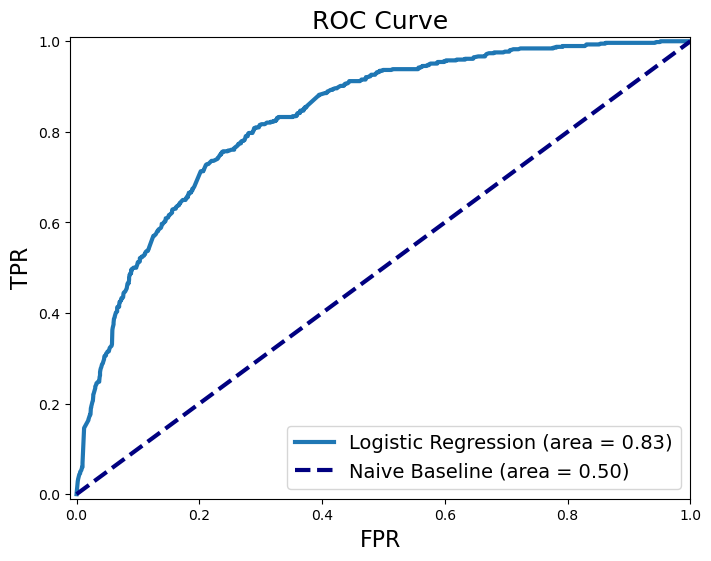

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr) #area under curve

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## 2. Categorical Encoding 

Just now with `statsmodels`, we left the handling of categorical variables to the model.
With `sklearn` packages, we need to do the categorical encoding ourselves.


Two widely used types of categorical encoding are "Dummy Encoding" and "One-hot encoding":
- Dummy encoding converts a variable that has n possible distinct values, into n-1 binary variables. 
- One-hot encoding converts a variable with n possible distinct values, into n binary variables.  

For regression-type problems One-hot Encoding is preferable as we wish to avoid perfect collinearity between the binary variables that are being generated by the encoding. In the classification problem however, we are not concerned about inflating factors and hence can choose either of the two schemes. They will produce equivalent encodings.

We will apply the encoding scheme to the `InternetService` variable.

In [20]:
churn_enc1 = pd.get_dummies(churn, columns = ['InternetService'])
churn_enc1

,Churn,MonthlyCharges,SeniorCitizen,PaymentMethod,tenure,Contract,InternetService_DSL,InternetService_Fiber optic,InternetService_No
0,0,29.85,0,Electronic check,1,Month-to-month,1,0,0
1,0,56.95,0,Mailed check,34,One year,1,0,0
2,1,53.85,0,Mailed check,2,Month-to-month,1,0,0
3,0,42.30,0,Bank transfer,45,One year,1,0,0
4,1,70.70,0,Electronic check,2,Month-to-month,0,1,0
...,...,...,...,...,...,...,...,...,...
7027,0,84.80,0,Mailed check,24,One year,1,0,0
7028,0,103.20,0,Credit card,72,One year,0,1,0
7029,0,29.60,0,Electronic check,11,Month-to-month,1,0,0
7030,1,74.40,1,Mailed check,4,Month-to-month,0,1,0


In [21]:
churn_enc2 = pd.get_dummies(churn, columns = ['InternetService'], drop_first=True)
churn_enc2

,Churn,MonthlyCharges,SeniorCitizen,PaymentMethod,tenure,Contract,InternetService_Fiber optic,InternetService_No
0,0,29.85,0,Electronic check,1,Month-to-month,0,0
1,0,56.95,0,Mailed check,34,One year,0,0
2,1,53.85,0,Mailed check,2,Month-to-month,0,0
3,0,42.30,0,Bank transfer,45,One year,0,0
4,1,70.70,0,Electronic check,2,Month-to-month,1,0
...,...,...,...,...,...,...,...,...
7027,0,84.80,0,Mailed check,24,One year,0,0
7028,0,103.20,0,Credit card,72,One year,1,0
7029,0,29.60,0,Electronic check,11,Month-to-month,0,0
7030,1,74.40,1,Mailed check,4,Month-to-month,1,0


`pd.get_dummies()` can also automatically detect the categorical columns if no specific columns are given.

By default `pd.get_dummies()` does one-hot enocoding. To do dummy encoding, you need to pass the parameter `drop_first=True`.

In [22]:
churn_enc = pd.get_dummies(churn, drop_first=True)
churn_enc

,Churn,MonthlyCharges,SeniorCitizen,tenure,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year
0,0,29.85,0,1,0,1,0,0,0,0,0
1,0,56.95,0,34,0,0,1,0,0,1,0
2,1,53.85,0,2,0,0,1,0,0,0,0
3,0,42.30,0,45,0,0,0,0,0,1,0
4,1,70.70,0,2,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7027,0,84.80,0,24,0,0,1,0,0,1,0
7028,0,103.20,0,72,1,0,0,1,0,1,0
7029,0,29.60,0,11,0,1,0,0,0,0,0
7030,1,74.40,1,4,0,0,1,1,0,0,0


In [23]:
new_col_names = {'PaymentMethod_Credit card':'PaymentMethod_Credit_card', 
                    'PaymentMethod_Electronic check':'PaymentMethod_Electronic_check',
                   'PaymentMethod_Mailed check':'PaymentMethod_Mailed_check', 
                    'InternetService_Fiber optic':'InternetService_Fiber_optic', 
                    'Contract_One year':'Contract_One_year',
                   'Contract_Two year':'Contract_Two_year'}

churn_enc.rename(columns= new_col_names,  errors="raise", inplace = True)

In [24]:
churn_enc.info()
churn_enc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Churn                           7032 non-null   int64  
 1   MonthlyCharges                  7032 non-null   float64
 2   SeniorCitizen                   7032 non-null   int64  
 3   tenure                          7032 non-null   int64  
 4   PaymentMethod_Credit_card       7032 non-null   uint8  
 5   PaymentMethod_Electronic_check  7032 non-null   uint8  
 6   PaymentMethod_Mailed_check      7032 non-null   uint8  
 7   InternetService_Fiber_optic     7032 non-null   uint8  
 8   InternetService_No              7032 non-null   uint8  
 9   Contract_One_year               7032 non-null   uint8  
 10  Contract_Two_year               7032 non-null   uint8  
dtypes: float64(1), int64(3), uint8(7)
memory usage: 267.9 KB


,Churn,MonthlyCharges,SeniorCitizen,tenure,PaymentMethod_Credit_card,PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,InternetService_Fiber_optic,InternetService_No,Contract_One_year,Contract_Two_year
0,0,29.85,0,1,0,1,0,0,0,0,0
1,0,56.95,0,34,0,0,1,0,0,1,0
2,1,53.85,0,2,0,0,1,0,0,0,0
3,0,42.30,0,45,0,0,0,0,0,1,0
4,1,70.70,0,2,0,1,0,1,0,0,0


In [25]:
churn_train_enc, churn_test_enc = train_test_split(churn_enc, test_size=0.3, random_state=88)
churn_train_enc.shape, churn_test_enc.shape

((4922, 11), (2110, 11))

In [26]:
logreg_ = smf.logit(formula = 'Churn ~ MonthlyCharges + SeniorCitizen + PaymentMethod_Electronic_check \
                              + InternetService_Fiber_optic + InternetService_No + tenure + Contract_One_year + Contract_Two_year',
                       data = churn_train_enc).fit()
print(logreg_.summary())

Optimization terminated successfully.
         Current function value: 0.421978
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4913
Method:                           MLE   Df Model:                            8
Date:                Thu, 21 Sep 2023   Pseudo R-squ.:                  0.2693
Time:                        23:36:51   Log-Likelihood:                -2077.0
converged:                       True   LL-Null:                       -2842.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.9454      0.191     -4.938     